In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import xgboost as xgb
import gseapy as gp
from gseapy import barplot, dotplot
import joblib

from utils import create_protein_peptide_map, update_protein_peptide_map

sns.set_theme(style="whitegrid")

In [2]:
path = "data/MALDI_IHC/correlations/"
path_results = f"{path}results/"
path_models = f"{path_results}models/"
path_peptides = "data/MALDI_IHC/results/peptides_mass_immuno_counts"

# Load the data

In [3]:
# Load the normalized MSI data
peaks = pd.read_pickle(f"{path}peaks_standardized_lesion.pkl")
pixels = pd.read_pickle(f"{path}pixels_filtered_lesion.pkl")

peaks.shape, pixels.shape

((1720272, 3492), (1720272, 15))

# Remove the unwanted sildes

In [4]:
# list of unwanted slides
bad_lames = ['13AG03225-06', '13AG06573-10', '544085-14', '546332-17', '549724-18', '549724-19', '549764-29', '549857-19', '549857-22', '552138-25']

# Remove the bad samples
peaks = peaks[~pixels['run'].isin(bad_lames)]
pixels = pixels[~pixels['run'].isin(bad_lames)]

In [5]:
# Exclude the pixels with defects
peaks = peaks[pixels["Density_Defects"] < 0.1]
pixels = pixels[pixels["Density_Defects"] < 0.1]

# Exclude the tumors pixels
peaks = peaks[pixels["Density_Tumor"] < 0.1]
pixels = pixels[pixels["Density_Tumor"] < 0.1]

# Reset the index
peaks.reset_index(drop=True, inplace=True)
pixels.reset_index(drop=True, inplace=True)

peaks.shape, pixels.shape

((884747, 3492), (884747, 15))

# Define the densities and a threshold for each pixel density

In [6]:
# Determine the densities of the selected pixels
densities = ["Density_CD8", "Density_Tumor", "Density_Stroma", "Density_Collagen"]

# Get the number of lames and densities
lames = pixels['run'].unique()
n_lames = len(lames)

# Define the threshold for each density
threshold = {
    'Density_CD8': 0.03,
    'Density_Tumor': 0.1,
    'Density_Stroma': 0.8,
    'Density_Collagen': 0.5
    }

# Predict the CD8 density using XGBoost

In [7]:
# load the models
model_reg = joblib.load(f"{path_models}xgb_regressor_CD8.pkl")

In [8]:
# Convert the data into DMatrix objects
dall = xgb.DMatrix(peaks, label=pixels['Density_CD8'])

In [9]:
# Make predictions
pixels['Predicted_CD8'] = model_reg.predict(dall)

# Map the proteins to peptides

In [10]:
# Create a protein peptide map from the peptide path
protein_peptide_map = create_protein_peptide_map(path_peptides, type=str)

# Match the protein peptide map with the peaks
protein_peptide_map = update_protein_peptide_map(protein_peptide_map, peaks.columns, tolerance=0.01)

# Compute the correlation
Compute the correlation between the predicted CD8 and the peptides masses

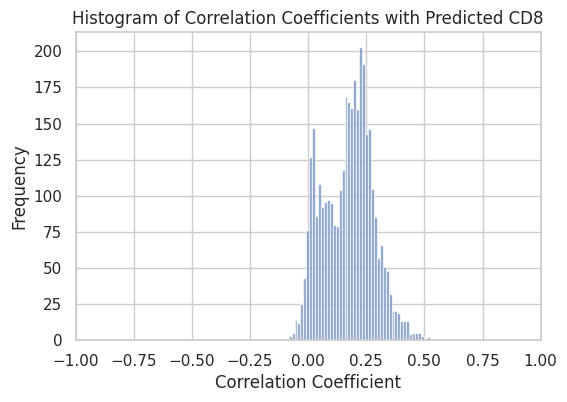

In [11]:
# Get the correlation between the peaks and the predicted CD8
peaks_corr_cd8 = peaks.corrwith(pixels['Predicted_CD8'], method='pearson', axis=0)

# plot a histogram of the correlation
plt.figure(figsize=(6, 4))
plt.hist(peaks_corr_cd8, bins=50, alpha=0.7)
plt.title('Histogram of Correlation Coefficients with Predicted CD8')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.xlim(-1, 1)
plt.show()

In [12]:
# Prepare the ranked list for functional enrichment analysis
ranked_list_df = pd.DataFrame({
    'mz': peaks.columns,
    'correlation': peaks_corr_cd8,
})

# Remove the na values
ranked_list_df = ranked_list_df.dropna()


ranked_list_df.reset_index(drop=True, inplace=True)

ranked_list_df.head()

,mz,correlation
0,500.2463,0.036894
1,500.3555,0.037864
2,501.2456,0.003478
3,501.3143,0.009294
4,502.2806,0.011358


In [13]:
prerank_results = gp.prerank(
    rnk=ranked_list_df,         # Your ranked list DataFrame
    gene_sets=protein_peptide_map, # Your protein-peptide mapping dictionary
    min_size=3,                # Minimum number of peptides from a protein present in the ranked list to consider the protein (adjust as needed)
    max_size=500,               # Maximum number of peptides (adjust as needed)
    permutation_num=10**5,       # Number of permutations for significance testing (1000 is standard)
    threads=40,
    outdir=None,               # Set to a directory path string to save results (e.g., './gsea_results')
    seed=42,                   # For reproducibility
    verbose=True               # Print progress
)

2025-04-18 16:40:04,866 [INFO] Parsing data files for GSEA.............................
2025-04-18 16:40:04,872 [INFO] 0000 gene_sets have been filtered out when max_size=500 and min_size=3
2025-04-18 16:40:04,873 [INFO] 0059 gene_sets used for further statistical testing.....
2025-04-18 16:40:04,873 [INFO] Start to run GSEA...Might take a while..................
2025-04-18 16:40:21,525 [INFO] Congratulations. GSEApy runs successfully................



In [14]:
# Get the main results DataFrame
results_df = prerank_results.res2d

# Order the results by NOM p-value
results_df = results_df.sort_values(by='NOM p-val', ascending=True)

results_df.head(10)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,CO1A1,0.422981,1.4503,0.00335,0.697471,0.50818,30/63,27.66%,1297.6131;2121.0722;1546.7972;1784.8748;1553.7...
1,prerank,CO3A1,0.419266,1.439727,0.00379,0.387984,0.54653,34/63,38.37%,1708.7884;2216.0842;836.4373;1093.5636;1706.79...
3,prerank,COJA1,0.375847,1.294996,0.0333,0.771359,0.96475,23/65,19.87%,1687.8398;1322.6698;1583.8176;1568.7849;620.28...
4,prerank,CO1A2,0.375425,1.28386,0.040262,0.682768,0.97677,33/61,36.63%,1547.7924;1564.7713;1562.7921;1703.844;852.468...
2,prerank,CTHR1,0.506576,1.38359,0.068665,0.448616,0.75114,5/13,22.62%,1670.7843;1619.8135;1516.659;1236.5603;2075.0048
6,prerank,TENR,0.350783,1.213373,0.083451,0.902926,0.99937,30/68,32.90%,2217.0723;1812.8246;2105.9637;1515.6025;1755.7...
5,prerank,TICN2,0.414722,1.281808,0.09748,0.579689,0.97851,10/26,18.67%,1534.6606;1106.551;1545.7503;1125.4946;1859.86...
9,prerank,CO5A2,0.33247,1.145043,0.171302,1.0,1.0,37/65,48.28%,2216.9802;1704.8412;1514.7346;1125.5704;1632.7...
11,prerank,CO5A1,0.315352,1.109897,0.21134,1.0,1.0,45/83,47.59%,852.3846;1629.7615;1688.8503;620.3035;1705.796...
7,prerank,FNDC7,0.363029,1.147796,0.223444,1.0,1.0,17/31,39.58%,1849.9186;1700.7609;1949.9749;1223.6419;1517.7...


In [15]:
# Create a directory for the results
os.makedirs(f"{path_results}FEA", exist_ok=True)

# Save the results
results_df.to_csv(f"{path_results}FEA/gsea_results_CD8.csv", index=False)

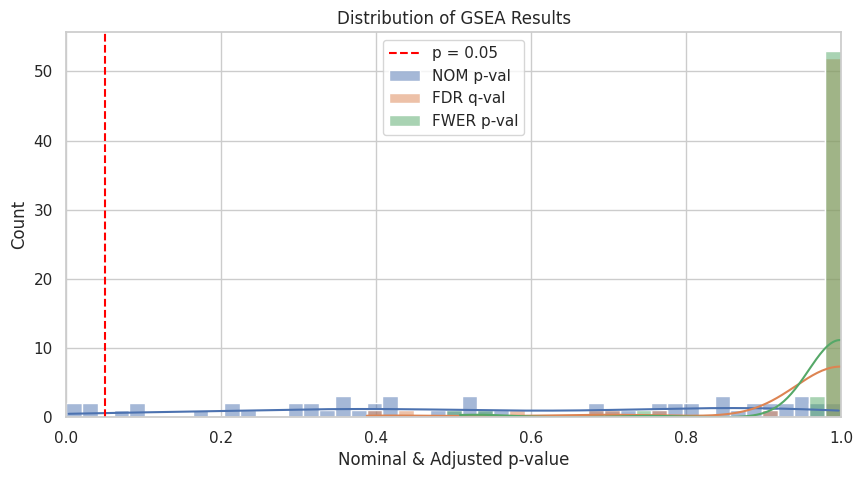

In [17]:
# Plotting the GSEA results
plt.figure(figsize=(10, 5))
bins = np.linspace(0, 1, 50)
sns.histplot(data=results_df, x='NOM p-val', bins=bins, kde=True, alpha=0.5, label='NOM p-val')
sns.histplot(data=results_df, x='FDR q-val', bins=bins, kde=True, alpha=0.5, label='FDR q-val')
sns.histplot(data=results_df, x='FWER p-val', bins=bins, kde=True, alpha=0.5, label='FWER p-val')
plt.axvline(x=0.05, color='red', linestyle='--', label='p = 0.05')
plt.title('Distribution of GSEA Results')
plt.xlabel('Nominal & Adjusted p-value')
# plt.yscale('log')
plt.xlim(0, 1)
plt.legend()
plt.show()

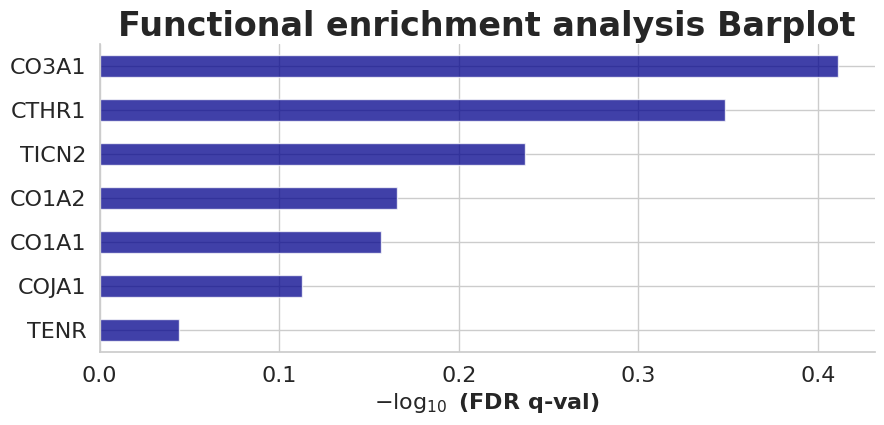

In [18]:
# Barplot
ax = barplot(prerank_results.res2d,
             column='FDR q-val',  # Column to plot
             cutoff=0.99,  # Cutoff for significance
             title='Functional enrichment analysis Barplot',
             figsize=(10, 4),
             color='darkblue',
             top_term=20,  # Top 10 terms
             bar_width=0.5,
             show=True)

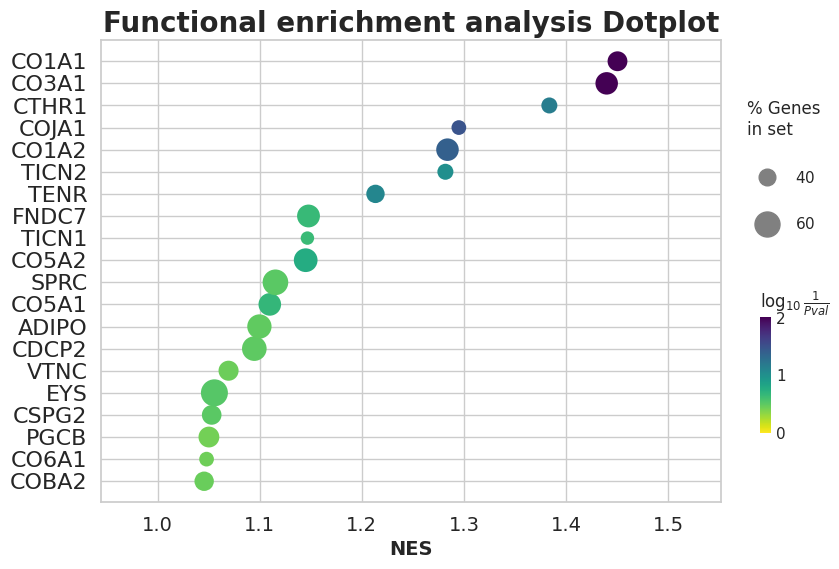

In [19]:
# Dotplot
ax = dotplot(prerank_results.res2d,
             column='NOM p-val',  # Column to plot
             cutoff=0.99,  # Cutoff for significance
             title='Functional enrichment analysis Dotplot',
             figsize=(10, 6),
             color='darkblue',
             top_term=20,  # Top 10 terms
             show=True)

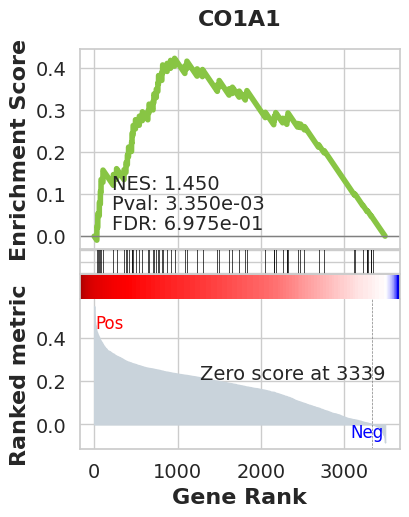

In [20]:
# GSEA plot
proteins = prerank_results.res2d.Term

axs = prerank_results.plot(terms=proteins[0])

# Perform GSEA for each slide separately

In [ ]:
# loop over all the lames
for lame in lames:
    # Get the correlation between the peaks and the predicted CD8
    peaks_corr_cd8 = peaks[pixels['run']==lame].corrwith(pixels[pixels['run']==lame]['Predicted_CD8'], method='pearson', axis=0)

    # Example Data (Replace with your actual data)
    ranked_list_df = pd.DataFrame({
        'mz': peaks.columns,
        'correlation': peaks_corr_cd8,
    })

    # Remove the na values
    ranked_list_df = ranked_list_df.dropna()
    ranked_list_df.reset_index(drop=True, inplace=True)

    # Perform functional enrichment analysis
    prerank_results = gp.prerank(
        rnk=ranked_list_df,         # Your ranked list DataFrame
        gene_sets=protein_peptide_map, # Your protein-peptide mapping dictionary
        min_size=3,                # Minimum number of peptides from a protein present in the ranked list to consider the protein (adjust as needed)
        max_size=500,               # Maximum number of peptides (adjust as needed)
        permutation_num=10**5,       # Number of permutations for significance testing (1000 is standard)
        threads=40,
        outdir=None,               # Set to a directory path string to save results (e.g., './gsea_results')
        seed=42,                   # For reproducibility
        verbose=True               # Print progress
    )

    # Get the main results DataFrame
    results_df = prerank_results.res2d

    # Order the results by NOM p-value
    results_df = results_df.sort_values(by='NOM p-val', ascending=True)
    
    # Save the results
    results_df.to_csv(f"{path_results}FEA/{lame}.csv", index=False)

    print(f"Results for {lame}:")
    print(results_df.head(10))